# DAX expansion Market activity - Python

### Overview
This notebook is the basis of this blog post : https://ganymde.cloud/dax-expansion.html

In this sample, we will get an insight on how an index impacts a stock liquidity. We will look back on how DAX index expansion from 30 to 40 stocks impacted liquidity for these new stocks leveraging several APIs we provide.

Following the announcement of Deutsche Böerse in 2020, the index became larger since <i>20 September 2021</i> by incorporating ten of the largest companies from Germany's MDAX listing 👇
* *Airbus SE, Brenntag SE, HelloFresh SE, Porsche SE, Puma SE, Qiagen NV, Sartorius AG (Pref. shares), Siemens Healthineers AG, Symrise AG and Zalando SE*

In order to understand the **index expansion impact on liquidity** for DAX components, we suggest to start with a purely technical indicator which is the **ticks count**, internally named `topolgy`. Each **market event** is pre-mapped, normalized and stored as a *tick* in our data store:
* Trades: timestamps, prices, sizes, trades Ids, trade conditions, etc.
* Book quotes (best bids and asks): timestamps, prices, sizes, etc.

This samples enables to retrieve **on-demand** ticks count data points by calling a dedicated service.

### Inputs/outputs
Tick count sample requires instruments' identifiers, date time intervals and time granularity as per inputs. It returns the ticks count data sampled using the input time granularity, readily available for on-the-fly analytics.

We will request **ticks count for the DAX components** before and after the index expansion, on *20 September 2021*. 
Then, we will compute **market activity movements** for each new component in order to understand the `integration into index impact on liquidity`.

### Services used
This sample uses *gRPC requests* in order to retrieve ticks from the dedicated hosted service. The queried endpoint in this script are:
* TopologiesService: to directly retrieve ticks objects from the server.

### Modules required
1. Systemathics packages:
    * *systemathics.apis.services.topology.v1*
    * *systemathics.apis.type.shared.v1*
    * *google.type*
2. Open source packages
    * *googleapis-common-protos*
    * *protobuf*
    * *grpcio*
    * *pandas*
    * *matpotlib* as per display package
    
***

# Run DAX expansion - Market activity

### Step 1: Import required packages

In [1]:
pip install googleapis-common-protos protobuf grpcio pandas matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install systemathics.apis

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import grpc
import pandas as pd
from datetime import date
from datetime import datetime
import google.type.date_pb2 as date
import systemathics.apis.type.shared.v1.level_pb2 as level
import systemathics.apis.type.shared.v1.identifier_pb2 as identifier
import systemathics.apis.services.topology.v1.topologies_pb2 as topologies
import systemathics.apis.services.topology.v1.topologies_pb2_grpc as topologies_service
import systemathics.apis.helpers.token_helpers as token_helpers
import systemathics.apis.helpers.channel_helpers as channel_helpers

### Step 2: Prepare API requests
The following code snippets retrieve authentication token to be used in upcomming API requests:

In [4]:
token = token_helpers.get_token()
display(token)

'Bearer eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6ImpwZDhjS2Z5Zi13QXkzOURpNENqWSJ9.eyJpc3MiOiJodHRwczovL2dhbnltZWRlLXByb2QuZXUuYXV0aDAuY29tLyIsInN1YiI6InJLMHMwN3dOZ3l3TzRIdHNCblYyTHFndmV4dzExQmw4QGNsaWVudHMiLCJhdWQiOiJodHRwczovL2dhbnltZWRlLXByb2QiLCJpYXQiOjE2NjMwNjgyMTksImV4cCI6MTY2NTY2MDIxOSwiYXpwIjoickswczA3d05neXdPNEh0c0JuVjJMcWd2ZXh3MTFCbDgiLCJzY29wZSI6ImFkbWluIGFydGVmYWN0cyBjaGFuZ2VzIGNvbXBvbmVudHMgZGFpbHlfYmFycyBkYWlseV9ib2xsaW5nZXIgZGFpbHlfY21hIGRhaWx5X2VtYSBkYWlseV9tYWNkIGRhaWx5X3ByaWNlcyBkYWlseV9yc2kgZGFpbHlfc21hIGRhaWx5X3ZvbGF0aWxpdHkgZGFpbHlfdndhcHMgZGl2aWRlbmRzIGlkZW50aWZpZXJfbWFwcGluZyBpbnRyYWRheV9iYXJzIGludHJhZGF5X2JvbGxpbmdlciBpbnRyYWRheV9jbWEgaW50cmFkYXlfZW1hIGludHJhZGF5X21hY2QgaW50cmFkYXlfcHJpY2VzIGludHJhZGF5X3JzaSBpbnRyYWRheV9zbWEgaW50cmFkYXlfdm9sYXRpbGl0eSBpbnRyYWRheV92d2FwcyBtZW1vcyBzcGxpdHMgc3RhdGljX2RhdGEgc3RhdGljX3NlY3RvciBzdXN0YWluYWJpbGl0eSB0aWNrX2JhcnMgdGlja19ib2xsaW5nZXIgdGlja19ib29rIHRpY2tfY21hIHRpY2tfY29uZGl0aW9ucyB0aWNrX2VtYSB0aWNrX3ByaWlwcyB0aWNrX3F1b3R

### Step 3: Prepare request parameters

#### 3.1 Instruments' selection
The following code snippet enables to set the **DAX components**, before and after index expansion. 
As we are using *ICE data services* as market data source, tickers are simply the `ICE symbols`.

In [5]:
old_components = ['E:ADSD', 'E:ALVD', 'E:BASD', 'E:BAYND', 'E:BEID', 'E:BMWD', 'E:CBKD', 'E:COND', 'E:DAID', 'E:DBKD', 'E:DB1D', 'E:LHAD', 'E:DPWD', 'E:DTED', 'E:EOAND', 'E:FRED', 'E:FMED', 'E:HEID', 'E:HEND', 'E:IFXD', 'E:LIND', 'E:MRKD', 'E:MUV2D', 'E:PSMD', 'E:RWED', 'E:SAPD', 'E:SIED', 'E:TKAD', 'E:VOWD', 'E:VNAD']
new_components = ['E:PUMD', 'E:ZALD', 'E:SHLD', 'E:SY1D', 'E:HFGD', 'E:SRTD', 'E:PAH3D', 'E:BNRD', 'E:QIAD', 'E:AIRP']

Each ticker is available in a specific ICE data location called `ICE data source` with a **source_Id**.

In [6]:
source = '840' # ICE data location for DAX tickers after source_Id migration  occured on "date to be added"

#### 3.2 Topologies parameters
The following code snippet enables to set the required parameters to call **TopologiesService**.

In [7]:
# set topology time granularity (daily, weekly...)
granularity = topologies.TOPOLOGY_GRANULARITY_DAILY

# set level: Trades or Trades and Book
my_level = level.LEVEL_TRADES_AND_BOOK

### Step 4: Retrieve data
The following code snippet creates a method to handle request creation to **TickTradesService** for a given instrument with previous chosen parameters.

In [8]:
# define method to handle topologies request creation for each instrument
def get_topologies_request(ticker, exchange, granularity, level):
    request = topologies.TopologiesRequest(identifier = identifier.Identifier(exchange = exchange, ticker = ticker),
                                           granularity = granularity,
                                           level = level)
    return request

The following code snippet creates a method that calls **TickTradesService** and returns *a pandas dataframe* containing **ticks counts** for a given list of instruments.

In [9]:
# define method to handle tick counts data for a given list of instruments (old/new DAX components)
def get_toplogies_data(tickers):
    ticks_data = pd.DataFrame({'Date': []})
    ticks_data = ticks_data.set_index('Date')

    # iterate all instrument identifiers: exhange/ticker pairs
    for i in range(len(tickers)):
        ticker = tickers[i]
        
        try:
            # open a gRPC channel
            with channel_helpers.get_grpc_channel() as channel:

                # instantiate the topologies service
                request = get_topologies_request(ticker, source, granularity, my_level)
                service = topologies_service.TopologiesServiceStub(channel)

                # process the topologies request
                response = service.Topologies(request=request, metadata = [('authorization', token)])

                # build data structure with: ticker, date and ticks count
                dates, ticks = [], []
                for entry in response.entries:
                    if entry.begin.year >= 2021 and entry.begin.month >= 6 and entry.begin.day >= 1:
                        dates.append(datetime(year=entry.begin.year,day=entry.begin.day, month=entry.begin.month))
                        ticks.append(entry.ticks_count)

                tmp_ticks_data = pd.DataFrame(data ={'Date': dates, f'{ticker}': ticks})
                tmp_ticks_data = tmp_ticks_data.set_index('Date')
                if (ticks_data.size == 0):
                    ticks_data = tmp_ticks_data
                else:
                    ticks_data = pd.merge(ticks_data, tmp_ticks_data, on="Date")
        except grpc.RpcError as e:
            display(e.code().name)
            display(e.details())
                
    return ticks_data

#### 4.1 DAX previous composition
The following code snippet calls the previous method and builds a *pandas dataframe* with `ticks counts for the DAX previous composition, total of 30 instruments`.

In [10]:
# get ticks count for the DAX previous composition
old_topologies = get_toplogies_data(old_components)

In [11]:
# display ticks count for the DAX previous composition
old_topologies

,E:ADSD,E:ALVD,E:BASD,E:BAYND,E:BEID,E:BMWD,E:CBKD,E:COND,E:DAID,E:DBKD,...,E:LIND,E:MRKD,E:MUV2D,E:PSMD,E:RWED,E:SAPD,E:SIED,E:TKAD,E:VOWD,E:VNAD
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,189002,194316,218956,195032,59487,220109,93038,272635,285668,194613,...,147825,82658,124568,65557,109625,198389,247197,142920,51415,97906
2021-06-02,183893,169752,175252,205812,87850,221023,123009,199355,249033,166475,...,124326,89038,107895,90416,135744,175438,258690,137595,43218,84695
2021-06-03,185735,189318,178017,169411,41275,281303,104857,251885,287160,185998,...,134744,90976,130585,64784,141203,213054,232036,104409,37882,83748
2021-06-04,171613,160258,169193,148048,36178,252605,100966,205555,221601,184229,...,109396,79128,105852,52690,112400,159633,216444,99757,25832,71315
2021-06-07,139334,165841,149518,152779,37751,221395,91844,232568,225360,177510,...,131920,68206,100212,42232,121803,201477,232683,139366,31371,77896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,210181,135988,228745,178571,87647,253268,67176,244255,278558,150458,...,113480,86791,117284,66704,105074,244409,255248,80266,17772,125347
2021-12-27,151613,128747,119601,112287,48278,159734,50562,128110,181247,130279,...,85247,47438,78586,31756,76716,170311,178494,54443,11533,107266
2021-12-28,172446,137330,129126,107780,70373,191176,67500,159789,209796,108825,...,77407,63317,101146,42891,80838,179302,192377,49131,19519,94966


#### 4.2 DAX new components
The following code snippet calls the previous method and builds a *pandas dataframe* with `ticks counts for the DAX new components, total of 10 instruments`.

In [12]:
# get ticks count for the DAX new components
new_topologies = get_toplogies_data(new_components)

In [13]:
# display ticks count for the DAX new components
new_topologies

,E:PUMD,E:ZALD,E:SHLD,E:SY1D,E:HFGD,E:SRTD,E:PAH3D,E:BNRD,E:QIAD,E:AIRP
Date,,,,,,,,,,
2021-06-01,69148,192647,73258,31056,103630,2467,107610,51453,49771,246476
2021-06-02,71828,171758,67373,44489,89306,2090,141180,47416,61690,235102
2021-06-03,68274,190896,63904,42581,86302,1837,112725,35587,68572,193425
2021-06-04,54792,196198,57849,30389,103351,2541,93633,35627,50330,138882
2021-06-07,57551,226596,47760,34688,106380,1118,79072,81917,60334,168515
...,...,...,...,...,...,...,...,...,...,...
2022-09-06,317085,245711,199994,139641,201958,11178,237475,178111,190463,420185
2022-09-07,234109,188037,257930,184642,272082,4425,264110,172775,183914,476829
2022-09-08,257717,234590,245159,173653,202906,9117,266191,171765,204417,473211


#### 4.3 Market activity analysis following DAX expansion

In [14]:
names = ['Puma SE', 'Zalando SE', 'Siemens Healthineers AG', 'Symrise AG', 'HelloFresh SE', 'Sartorius AG', ' Porsche Automobil Holding SE', 'Brenntag SE', 'QIAGEN NV', 'Airbus SE']

In [15]:
# we start from June 1st until December 2nd , including September 20th, DAX expansion date
start_date = "2021-06-01"
end_date = "2021-12-02"
change_date = "2021-09-20"
day_before_change = "2021-09-19"

# compute ticks count percentage change
ratios = (new_topologies[change_date:end_date].mean() - new_topologies[start_date:day_before_change].mean()) / new_topologies[start_date:day_before_change].mean()
liquidity_ratios = round(ratios*100, 2)

# format data for display purposes
liquidity = pd.DataFrame({'Name': names,'Ticker': liquidity_ratios.index, 'Liquidity movement (%)': liquidity_ratios.values})
liquidity

,Name,Ticker,Liquidity movement (%)
0,Puma SE,E:PUMD,88.62
1,Zalando SE,E:ZALD,12.01
2,Siemens Healthineers AG,E:SHLD,52.25
3,Symrise AG,E:SY1D,88.03
4,HelloFresh SE,E:HFGD,59.18
5,Sartorius AG,E:SRTD,4.97
6,Porsche Automobil Holding SE,E:PAH3D,60.85
7,Brenntag SE,E:BNRD,65.98
8,QIAGEN NV,E:QIAD,61.35
9,Airbus SE,E:AIRP,27.72


### Step 5: Visualize data

[]

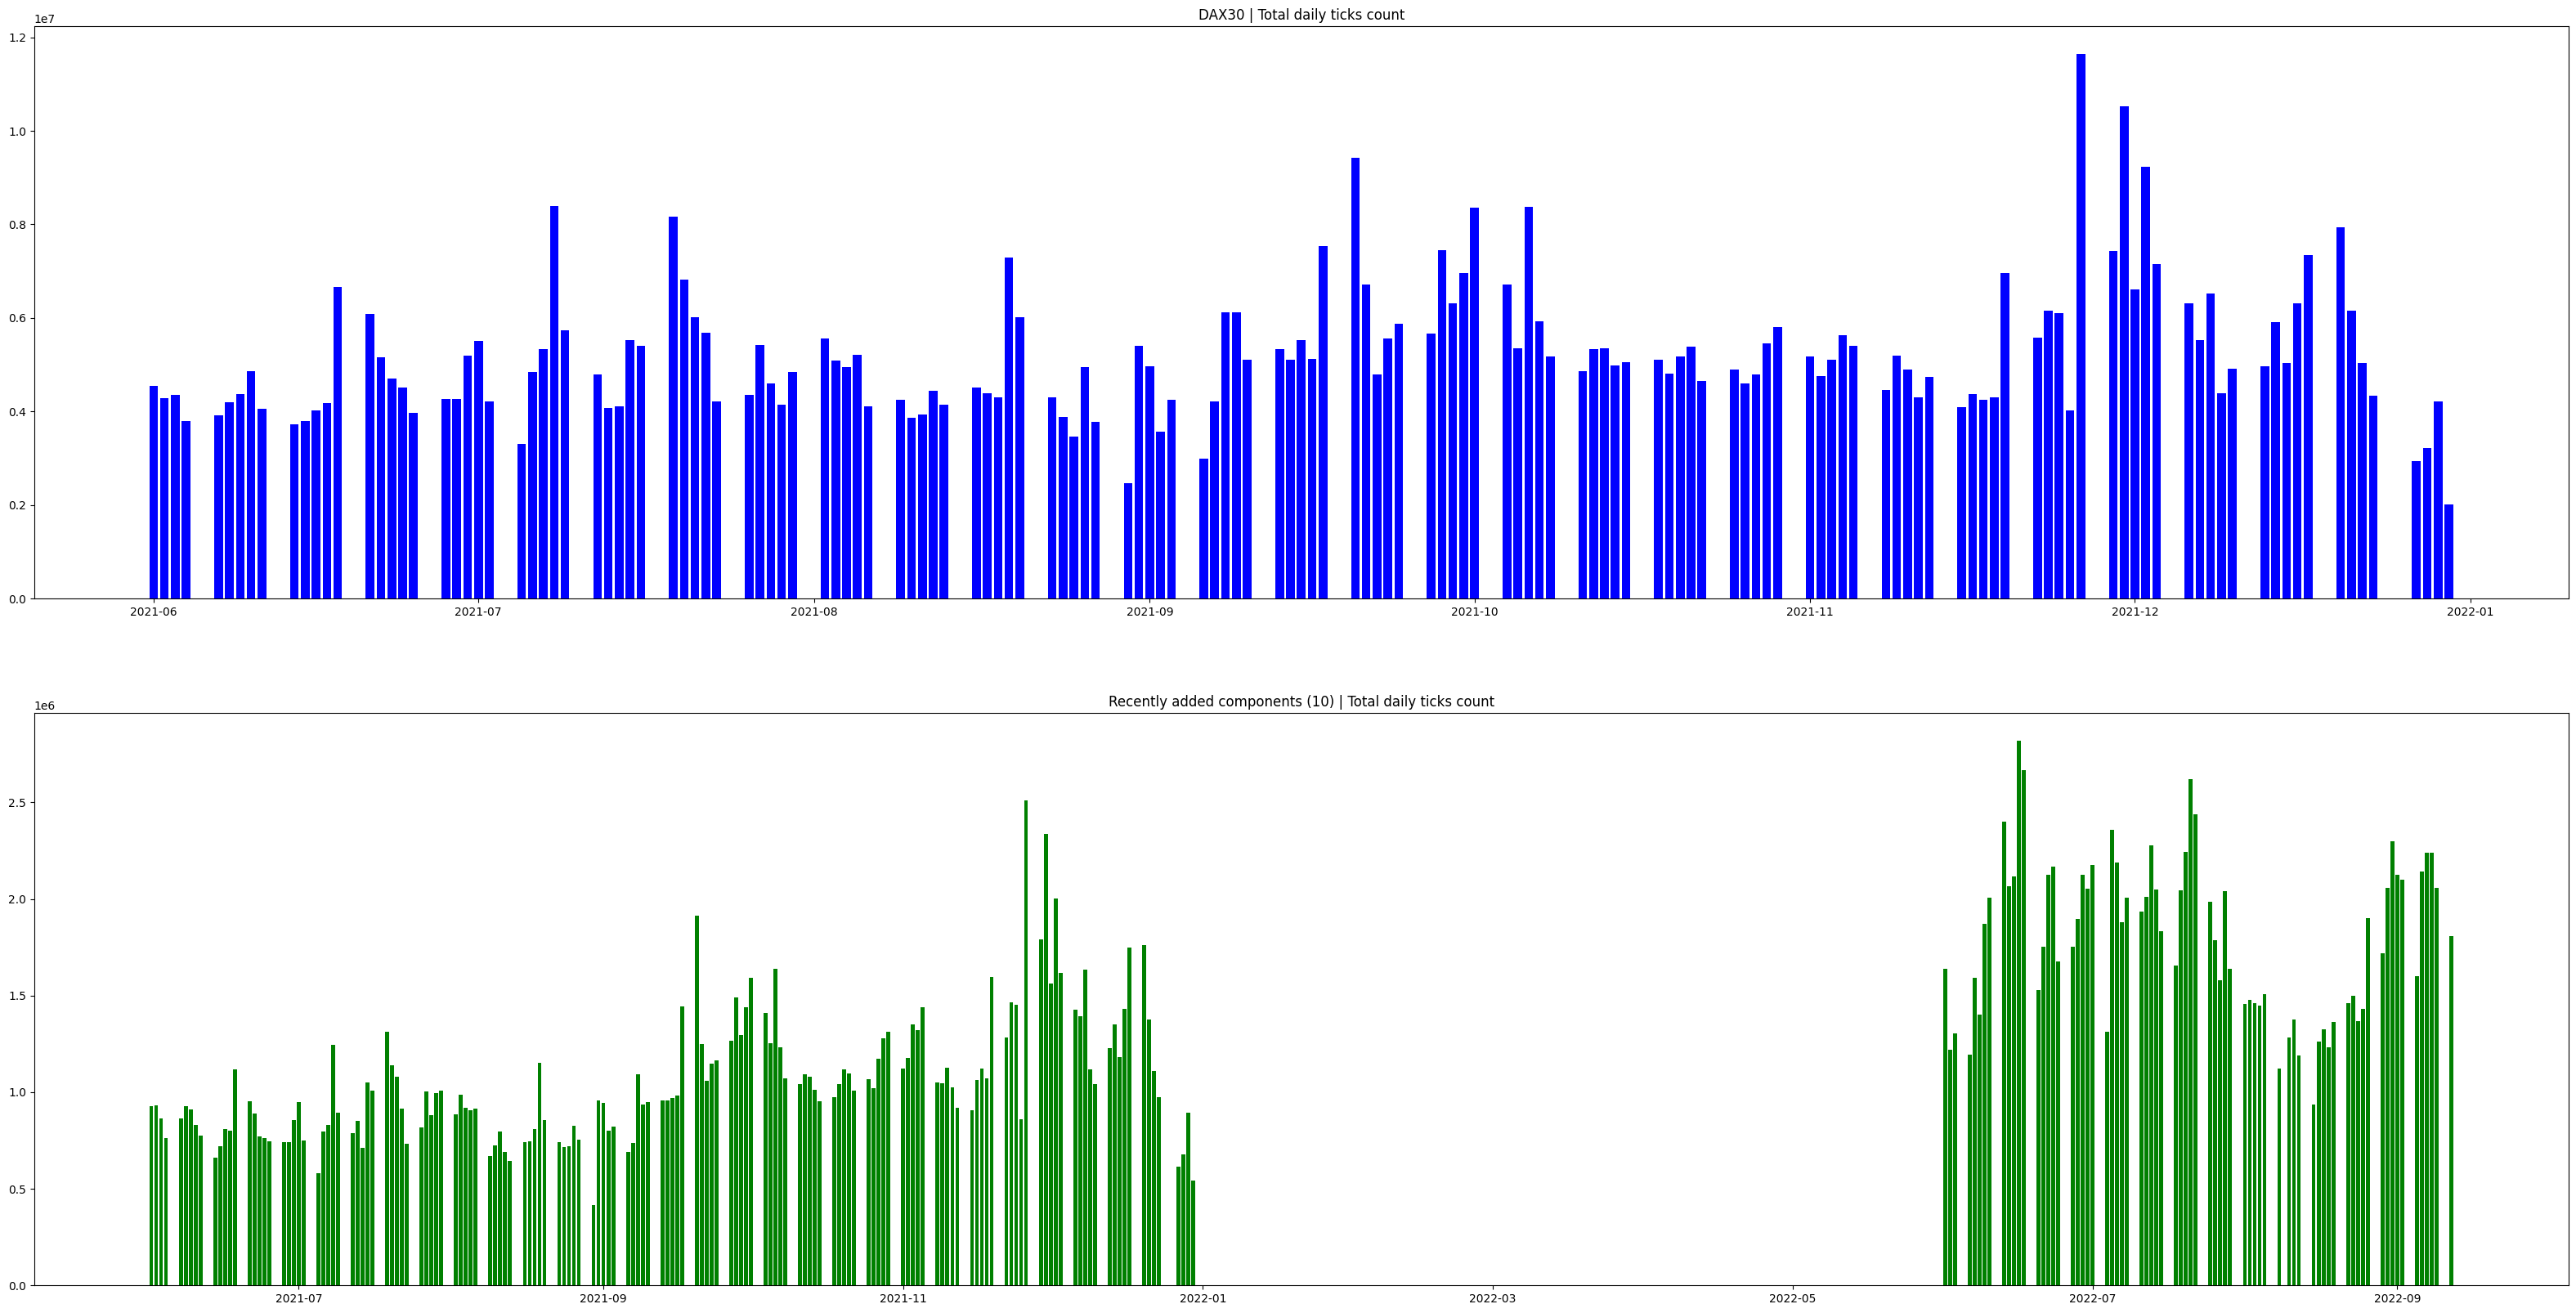

In [17]:
import matplotlib.pyplot as plt

num_rows = 2
num_cols = 1
fig,axs = plt.subplots(num_rows,num_cols, figsize=(40,20))

axs[0].bar(old_topologies.index, old_topologies.sum(axis=1) , color="blue", label="DAX30 | Total daily ticks count")
axs[0].set_title("DAX30 | Total daily ticks count")

axs[1].bar(new_topologies.index, new_topologies.sum(axis=1) , color="green", label="Recently added components | Total daily ticks count")
axs[1].set_title("Recently added components (10) | Total daily ticks count")

# plot
plt.plot()